In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import time
import math
import timeit
plt.style.use('ggplot')
start_time = dt.datetime.now()
%matplotlib inline

In [2]:
data=pd.read_csv('clean_card_transaction.csv',converters={'Merchnum': lambda x:str(x),'Cardnum':lambda x:str(x)})
data.shape

(96397, 10)

In [3]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


# Day of Week Target Encoding

In [4]:
data['Date']=pd.to_datetime(data.Date)

In [5]:
#Day of Week Target Encoding
data['dow']=data.Date.apply(lambda x: calendar.day_name[x.weekday()])

# Separate the OOT
train_set=data[data.Date<'2010-11-01']

#Statistical Smoothing
c=4;nmid=20;y_avg=train_set['Fraud'].mean()
y_dow=train_set.groupby('dow')['Fraud'].mean()
num=train_set.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['dow_risk']=data.dow.map(y_dow_smooth)

# delete files that we don't need any more to free up memory
del train_set

y_dow=y_dow.reset_index()
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')

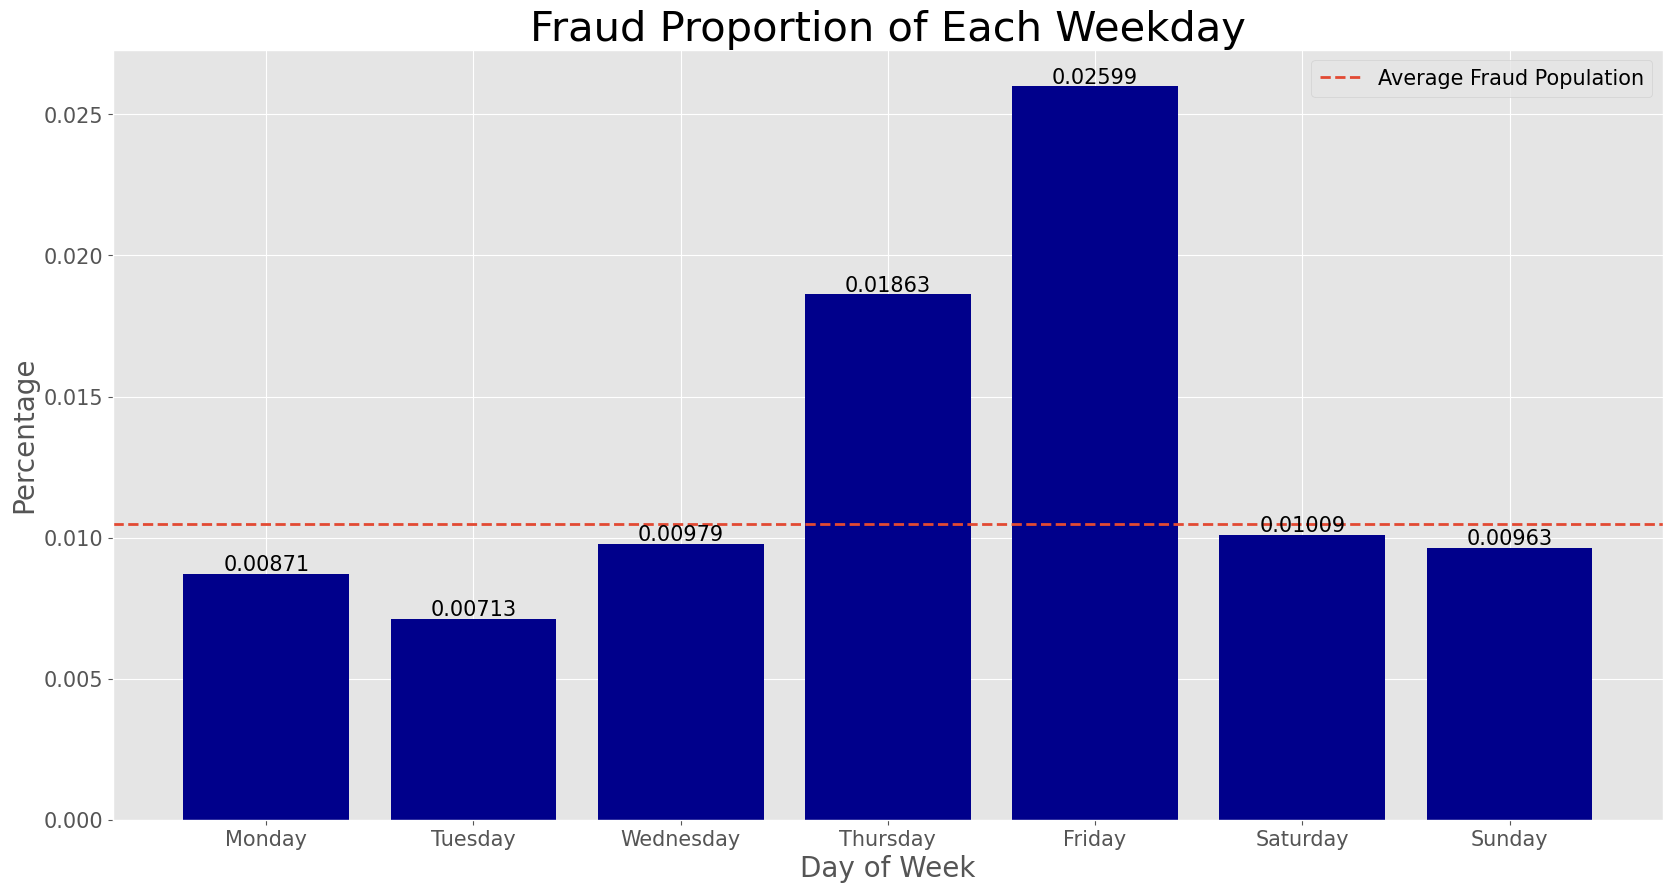

In [6]:
#plot
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_dow,x=y_dow.index,height='Fraud',color='darkblue')
#ax.set_ylim(bottom=.013)
ax.axhline(y=y_avg,ls='--',lw=2)

for i,v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center',fontsize=15)

plt.legend(['Average Fraud Population'],fontsize=15)
plt.xlabel("Day of Week", fontsize = 20)
plt.ylabel("Percentage", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Fraud Proportion of Each Weekday", fontsize = 30)
plt.savefig('risktable.png')
plt.show()

# Benford's law Variables

In [7]:
bf = data.copy()
bf['amount_100'] = (bf['Amount'] *100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
droplist = dropfedex.index.tolist()
bf1 = bf.drop(droplist)
bf1['bin'] = bf1['first_digit'].apply(lambda x: "low" if x == "1" else ("low" if x == "2" else "high"))

In [8]:
card_bf = bf1.groupby(['Cardnum','bin']).agg({'bin':['count']}).reset_index()
card_bf.columns = ['Cardnum', 'bin', 'count']
card_bf = card_bf.pivot_table(index = 'Cardnum',columns = 'bin', values = 'count', aggfunc = 'sum').reset_index()
card_bf.columns = ['Cardnum','n_high','n_low']
card_bf = card_bf.fillna(1)

In [9]:
#calculating R, 1/R, U, n, t，U_smoothed
c = 3
n_mid=15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x, y: max(x,y),card_bf['R'], card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low'] 
card_bf['t'] = ((card_bf['n'] - n_mid)/c)
card_bf['U_smoothed'] = list(map(lambda x, y: (1+(x-1)/(1 + math.exp(-y))),card_bf['U'], card_bf['t']))
card_bf['U_smoothed'] = card_bf['U_smoothed']

In [10]:
merch_bf = bf1.groupby(['Merchnum','bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns = ['Merchnum','bin','count']
merch_bf = merch_bf.pivot_table(index = 'Merchnum',columns = 'bin', values = 'count', aggfunc = 'sum').reset_index()
merch_bf.columns = ['Merchnum','n_high','n_low']
merch_bf = merch_bf.fillna(1)

In [11]:
#calculating R, 1/R, U, n, t，U_smoothed
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x, y: max(x,y),merch_bf['R'], merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low'] 
merch_bf['t'] = ((merch_bf['n'] - n_mid)/c)
merch_bf['U_smoothed'] = list(map(lambda x, y: (1+(x-1)/(1 + math.exp(-y))),merch_bf['U'], merch_bf['t']))
merch_bf['U_smoothed'] = merch_bf['U_smoothed']

In [12]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)

In [13]:
card_bf.set_index('Cardnum', inplace=True)
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'], ascending = False).head(3)

,U_smoothed
Cardnum,
5142253356,13.371199
5142299705,9.027976
5142197563,8.150852


In [14]:
merch_bf.set_index('Merchnum', inplace=True)
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'], ascending = False).head(3)

,U_smoothed
Merchnum,
991808369338,165.145985
8078200641472,64.663981
308904389335,48.357557


In [15]:
final = data.copy()
final = final.merge(card_Ustar, how = 'left', left_on = 'Cardnum', right_on = card_Ustar.index)
final = final.rename(columns = {'U_smoothed': 'U*_cardnum'})
final = final.merge(merch_Ustar, how = 'left', left_on = 'Merchnum', right_on = merch_Ustar.index)
final = final.rename(columns = {'U_smoothed': 'U*_merchnum'})

In [16]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,2.178008,NaN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,1.044105,NaN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,2.178008,NaN


# make entities

In [17]:
data = final.copy()
data['card_merch']= data.Cardnum + data.Merchnum
data['card_zip']= data.Cardnum + data['Merch zip']
data['card_state']=data.Cardnum + data['Merch state']
data['merch_zip']= data.Merchnum + data['Merch zip']
data['merch_state']=data.Merchnum + data['Merch state']

In [18]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'U*_cardnum', 'U*_merchnum', 'card_merch', 'card_zip',
       'card_state', 'merch_zip', 'merch_state'],
      dtype='object')

In [19]:
entities = ['Cardnum', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'card_merch', 'card_zip', 'card_state', 'merch_zip',
       'merch_state']

# make variables

In [20]:
df1 = data.copy()
final = data.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum


In [21]:
start = timeit.default_timer()
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')
    
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
final.columns




Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Run time for the last entity ----------------- 4.749023800000001s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:30: PerformanceWarning: DataFrame is highly frag

Merchnum amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merchnum_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

Merchnum amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merchnum_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

Merchnum amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

Merchnum amount variables over past 60 ---> Done
Run time for the last entity ----------------- 26.337371599999997s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



Merch description_day_since ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_0 ---> Done
Merch description amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_1 ---> Done
Merch description amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_3 ---> Done
Merch description amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_7 ---> Done
Merch description amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_14 ---> Done
Merch description amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:30: PerformanceWarning: DataFrame is highly frag

Merch description amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch description_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

Merch description amount variables over past 60 ---> Done
Run time for the last entity ----------------- 5.630200899999998s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



Merch state_day_since ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch state_count_0 ---> Done
Merch state amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch state_count_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:30: PerformanceWarning: DataFrame is highly frag

Merch state amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch state_count_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

Merch state amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merch state_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

Merch state amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merch state_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

Merch state amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merch state_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

Merch state amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merch state_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

Merch state amount variables over past 60 ---> Done
Run time for the last entity ----------------- 188.60246790000002s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



Merch zip_day_since ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch zip_count_0 ---> Done
Merch zip amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch zip_count_1 ---> Done
Merch zip amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch zip_count_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]


Merch zip amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Merch zip_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

Merch zip amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merch zip_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

Merch zip amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


Merch zip_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

Merch zip amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merch zip_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

Merch zip amount variables over past 60 ---> Done
Run time for the last entity ----------------- 53.597068999999976s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa


card_merch_day_since ---> Done
card_merch_count_0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

card_merch amount variables over past 0 ---> Done
card_merch_count_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_merch amount variables over past 1 ---> Done
card_merch_count_3 ---> Done
card_merch amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

card_merch_count_7 ---> Done
card_merch amount variables over past 7 ---> Done
card_merch_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

card_merch amount variables over past 14 ---> Done
card_merch_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

card_merch amount variables over past 30 ---> Done
card_merch_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

card_merch amount variables over past 60 ---> Done
Run time for the last entity ----------------- 2.5789266000000453s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa


card_zip_day_since ---> Done
card_zip_count_0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

card_zip amount variables over past 0 ---> Done
card_zip_count_1 ---> Done
card_zip amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_zip_count_3 ---> Done
card_zip amount variables over past 3 ---> Done
card_zip_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

card_zip amount variables over past 7 ---> Done
card_zip_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

card_zip amount variables over past 14 ---> Done
card_zip_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_zip amount variables over past 30 ---> Done
card_zip_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_zip amount variables over past 60 ---> Done
Run time for the last entity ----------------- 2.0602385000000254s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa


card_state_day_since ---> Done
card_state_count_0 ---> Done
card_state amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_state_count_1 ---> Done
card_state amount variables over past 1 ---> Done
card_state_count_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

card_state amount variables over past 3 ---> Done
card_state_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

card_state amount variables over past 7 ---> Done
card_state_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_state amount variables over past 14 ---> Done
card_state_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_state amount variables over past 30 ---> Done
card_state_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

card_state amount variables over past 60 ---> Done
Run time for the last entity ----------------- 2.4629085999999916s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



merch_zip_day_since ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_zip_count_0 ---> Done
merch_zip amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_zip_count_1 ---> Done
merch_zip amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_zip_count_3 ---> Done
merch_zip amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_zip_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

merch_zip amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_zip_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

merch_zip amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


merch_zip_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

merch_zip amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

merch_zip amount variables over past 60 ---> Done
Run time for the last entity ----------------- 25.40106689999999s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



merch_state_day_since ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_state_count_0 ---> Done
merch_state amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_state_count_1 ---> Done
merch_state amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_state_count_3 ---> Done
merch_state amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_state_count_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

merch_state amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

merch_state_count_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly frag

merch_state amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


merch_state_count_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragme

merch_state amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_count_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:27: PerformanceWarning: DataFrame is highly fragment

merch_state amount variables over past 60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\2573022514.py:30: PerformanceWarning: DataFrame is highly frag

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'merch_state_actual/toal_30', 'merch_state_count_60',
       'merch_state_avg_60', 'merch_state_max_60', 'merch_state_med_60',
       'merch_state_total_60', 'merch_state_actual/avg_60',
       'merch_state_actual/max_60', 'merch_state_actual/med_60',
       'merch_state_actual/toal_60'],
      dtype='object', length=659)

In [22]:
len(final.columns)

659

In [23]:
df2 = final.copy()

start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30','60']:
            df2[ent + '_count_' + d + '_by_' + dd] =\
            df2[ent + '_count_' + d]/(df2[ent + '_count_' + dd])/float(dd)
            print(ent + '_count_' + d + '_by_' + dd)

Cardnum_count_0_by_7
Cardnum_count_0_by_14
Cardnum_count_0_by_30
Cardnum_count_0_by_60
Cardnum_count_1_by_7
Cardnum_count_1_by_14
Cardnum_count_1_by_30
Cardnum_count_1_by_60
Merchnum_count_0_by_7
Merchnum_count_0_by_14
Merchnum_count_0_by_30
Merchnum_count_0_by_60
Merchnum_count_1_by_7
Merchnum_count_1_by_14
Merchnum_count_1_by_30
Merchnum_count_1_by_60
Merch description_count_0_by_7
Merch description_count_0_by_14
Merch description_count_0_by_30
Merch description_count_0_by_60
Merch description_count_1_by_7
Merch description_count_1_by_14
Merch description_count_1_by_30
Merch description_count_1_by_60
Merch state_count_0_by_7
Merch state_count_0_by_14
Merch state_count_0_by_30
Merch state_count_0_by_60
Merch state_count_1_by_7
Merch state_count_1_by_14
Merch state_count_1_by_30
Merch state_count_1_by_60
Merch zip_count_0_by_7
Merch zip_count_0_by_14
Merch zip_count_0_by_30
Merch zip_count_0_by_60
Merch zip_count_1_by_7
Merch zip_count_1_by_14
Merch zip_count_1_by_30
Merch zip_count_1_

In [24]:
len(df2.columns)

739

In [25]:
start = timeit.default_timer()
# velocity days since ratio
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30','60']:
            print(ent)
            df2[ent + '_vdratio_' + d  + 'by' + dd] = df2[ent + '_count_' + d + '_by_' + dd]/(df2[ent + '_day_since']+1)


Cardnum
Cardnum
Cardnum
Cardnum
Cardnum
Cardnum
Cardnum
Cardnum
Merchnum
Merchnum
Merchnum
Merchnum
Merchnum
Merchnum
Merchnum
Merchnum
Merch description
Merch description
Merch description
Merch description
Merch description
Merch description
Merch description
Merch description
Merch state
Merch state
Merch state
Merch state
Merch state
Merch state
Merch state
Merch state
Merch zip
Merch zip
Merch zip
Merch zip
Merch zip
Merch zip
Merch zip
Merch zip
card_merch
card_merch
card_merch
card_merch
card_merch
card_merch
card_merch
card_merch
card_zip
card_zip
card_zip
card_zip
card_zip
card_zip
card_zip
card_zip
card_state
card_state
card_state
card_state
card_state
card_state
card_state
card_state
merch_zip
merch_zip
merch_zip
merch_zip
merch_zip
merch_zip
merch_zip
merch_zip
merch_state
merch_state
merch_state
merch_state
merch_state
merch_state
merch_state
merch_state


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3096799484.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[ent + '_vdratio_' + d  + 'by' + dd] = df2[ent + '_count_' + d + '_by_' + dd]/(df2[ent + '_day_since']+1)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3096799484.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[ent + '_vdratio_' + d  + 'by' + dd] = df2[ent + '_count_' + d + '_by_' + dd]/(df2[ent + '_day_since']+1)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3096799484.py:7: PerformanceWarning: DataFr

In [26]:
len(df2.columns)

819

In [27]:
# Cross entity uniqueness variables
final = df2.copy()
for i in entities:
    for v in entities:
        if i==v:
            continue
        else:
            df_c=df1[['Recnum','Date',i]]
            df_d=df1[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
        for t in [1,3,7,14,30,60]:
            count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['Recnum'])[v].nunique()
            final[col_name]=final.Recnum.map(mapper)
            print(col_name + ' ---> Done')



Cardnum_unique_count_for_Merchnum_1 ---> Done
Cardnum_unique_count_for_Merchnum_3 ---> Done
Cardnum_unique_count_for_Merchnum_7 ---> Done
Cardnum_unique_count_for_Merchnum_14 ---> Done
Cardnum_unique_count_for_Merchnum_30 ---> Done
Cardnum_unique_count_for_Merchnum_60 ---> Done
Cardnum_unique_count_for_Merch description_1 ---> Done
Cardnum_unique_count_for_Merch description_3 ---> Done
Cardnum_unique_count_for_Merch description_7 ---> Done
Cardnum_unique_count_for_Merch description_14 ---> Done
Cardnum_unique_count_for_Merch description_30 ---> Done
Cardnum_unique_count_for_Merch description_60 ---> Done
Cardnum_unique_count_for_Merch state_1 ---> Done
Cardnum_unique_count_for_Merch state_3 ---> Done
Cardnum_unique_count_for_Merch state_7 ---> Done
Cardnum_unique_count_for_Merch state_14 ---> Done
Cardnum_unique_count_for_Merch state_30 ---> Done
Cardnum_unique_count_for_Merch state_60 ---> Done
Cardnum_unique_count_for_Merch zip_1 ---> Done
Cardnum_unique_count_for_Merch zip_3 ---> Do

C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merchnum_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Cardnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Cardnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merchnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merchnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_merch_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_merch_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch description_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Cardnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Cardnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merchnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merchnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch description_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch description_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_merch_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_merch_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch state_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Cardnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Cardnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merchnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merchnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch description_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch description_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_merch_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_merch_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


Merch zip_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Cardnum_1 ---> Done
card_merch_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Cardnum_7 ---> Done
card_merch_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merchnum_1 ---> Done
card_merch_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merchnum_7 ---> Done
card_merch_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch description_1 ---> Done
card_merch_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch description_7 ---> Done
card_merch_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

card_merch_unique_count_for_Merch state_1 ---> Done
card_merch_unique_count_for_Merch state_3 ---> Done
card_merch_unique_count_for_Merch state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch state_14 ---> Done
card_merch_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch zip_1 ---> Done
card_merch_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch zip_7 ---> Done
card_merch_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_Merch zip_30 ---> Done
card_merch_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_card_zip_1 ---> Done
card_merch_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_card_zip_7 ---> Done
card_merch_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_card_zip_30 ---> Done
card_merch_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_card_state_1 ---> Done
card_merch_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_card_state_7 ---> Done
card_merch_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_card_state_30 ---> Done
card_merch_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_zip_1 ---> Done
card_merch_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_zip_7 ---> Done
card_merch_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_state_1 ---> Done
card_merch_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_state_7 ---> Done
card_merch_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_merch_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Cardnum_1 ---> Done
card_zip_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Cardnum_7 ---> Done
card_zip_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merchnum_1 ---> Done
card_zip_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merchnum_7 ---> Done
card_zip_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch description_1 ---> Done
card_zip_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch description_7 ---> Done
card_zip_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch state_1 ---> Done
card_zip_unique_count_for_Merch state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch state_7 ---> Done
card_zip_unique_count_for_Merch state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch zip_1 ---> Done
card_zip_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch zip_7 ---> Done
card_zip_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_merch_1 ---> Done
card_zip_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_merch_7 ---> Done
card_zip_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_state_1 ---> Done
card_zip_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_state_7 ---> Done
card_zip_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_zip_1 ---> Done
card_zip_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_zip_7 ---> Done
card_zip_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_state_1 ---> Done
card_zip_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_state_7 ---> Done
card_zip_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_zip_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Cardnum_1 ---> Done
card_state_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Cardnum_7 ---> Done
card_state_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merchnum_1 ---> Done
card_state_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merchnum_7 ---> Done
card_state_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch description_1 ---> Done
card_state_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch description_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch state_1 ---> Done
card_state_unique_count_for_Merch state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch state_7 ---> Done
card_state_unique_count_for_Merch state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch zip_1 ---> Done
card_state_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_merch_1 ---> Done
card_state_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_merch_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_zip_1 ---> Done
card_state_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_zip_7 ---> Done
card_state_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_zip_1 ---> Done
card_state_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_state_1 ---> Done
card_state_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


card_state_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Cardnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Cardnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merchnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merchnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch description_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch description_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_merch_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_merch_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_merch_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_merch_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_merch_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_merch_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_merch_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_zip_unique_count_for_merch_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Cardnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Cardnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Cardnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Cardnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Cardnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Cardnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merchnum_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merchnum_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merchnum_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merchnum_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merchnum_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merchnum_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch description_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch description_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch description_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch description_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch description_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch description_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_Merch zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_merch_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_merch_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_merch_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_merch_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_merch_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_merch_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_zip_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_state_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_state_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_state_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_state_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_state_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_card_state_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_merch_zip_1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_merch_zip_3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_merch_zip_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_merch_zip_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


merch_state_unique_count_for_merch_zip_30 ---> Done
merch_state_unique_count_for_merch_zip_60 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\380136522.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)


In [28]:
len(final.columns)

1359

In [29]:
df2 = final.copy()
final = df2.copy()
# variability
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')


Run time for the last entity ----------------- 3499.5447732000002s
Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> 

C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_merch_variability_avg_3 ---> Done
card_merch_variability_max_3 ---> Done
card_merch_variability_med_3 ---> Done
card_merch amount variables over past 3 ---> Done
card_merch_variability_avg_7 ---> Done
card_merch_variability_max_7 ---> Done
card_merch_variability_med_7 ---> Done
card_merch amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_merch_variability_avg_14 ---> Done
card_merch_variability_max_14 ---> Done
card_merch_variability_med_14 ---> Done
card_merch amount variables over past 14 ---> Done
card_merch_variability_avg_30 ---> Done
card_merch_variability_max_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_merch_variability_med_30 ---> Done
card_merch amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.172456599999805s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_zip_variability_avg_0 ---> Done
card_zip_variability_max_0 ---> Done
card_zip_variability_med_0 ---> Done
card_zip amount variables over past 0 ---> Done
card_zip_variability_avg_1 ---> Done
card_zip_variability_max_1 ---> Done
card_zip_variability_med_1 ---> Done
card_zip amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_zip_variability_avg_3 ---> Done
card_zip_variability_max_3 ---> Done
card_zip_variability_med_3 ---> Done
card_zip amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_zip_variability_avg_7 ---> Done
card_zip_variability_max_7 ---> Done
card_zip_variability_med_7 ---> Done
card_zip amount variables over past 7 ---> Done
card_zip_variability_avg_14 ---> Done
card_zip_variability_max_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_zip_variability_med_14 ---> Done
card_zip amount variables over past 14 ---> Done
card_zip_variability_avg_30 ---> Done
card_zip_variability_max_30 ---> Done
card_zip_variability_med_30 ---> Done
card_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.441106999999647s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_state_variability_avg_0 ---> Done
card_state_variability_max_0 ---> Done
card_state_variability_med_0 ---> Done
card_state amount variables over past 0 ---> Done
card_state_variability_avg_1 ---> Done
card_state_variability_max_1 ---> Done
card_state_variability_med_1 ---> Done
card_state amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_state_variability_avg_3 ---> Done
card_state_variability_max_3 ---> Done
card_state_variability_med_3 ---> Done
card_state amount variables over past 3 ---> Done
card_state_variability_avg_7 ---> Done
card_state_variability_max_7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

card_state_variability_med_7 ---> Done
card_state amount variables over past 7 ---> Done
card_state_variability_avg_14 ---> Done
card_state_variability_max_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_state_variability_med_14 ---> Done
card_state amount variables over past 14 ---> Done
card_state_variability_avg_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_state_variability_max_30 ---> Done
card_state_variability_med_30 ---> Done
card_state amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.6903772000000572s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_zip_variability_avg_0 ---> Done
merch_zip_variability_max_0 ---> Done
merch_zip_variability_med_0 ---> Done
merch_zip amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_zip_variability_avg_1 ---> Done
merch_zip_variability_max_1 ---> Done
merch_zip_variability_med_1 ---> Done
merch_zip amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_zip_variability_avg_3 ---> Done
merch_zip_variability_max_3 ---> Done
merch_zip_variability_med_3 ---> Done
merch_zip amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_zip_variability_avg_7 ---> Done
merch_zip_variability_max_7 ---> Done
merch_zip_variability_med_7 ---> Done
merch_zip amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_14 ---> Done
merch_zip_variability_max_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_14 ---> Done
merch_zip amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_30 ---> Done
merch_zip_variability_max_30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_30 ---> Done
merch_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 18.31070210000007s


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_state_variability_avg_0 ---> Done
merch_state_variability_max_0 ---> Done
merch_state_variability_med_0 ---> Done
merch_state amount variables over past 0 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_state_variability_avg_1 ---> Done
merch_state_variability_max_1 ---> Done
merch_state_variability_med_1 ---> Done
merch_state amount variables over past 1 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_state_variability_avg_3 ---> Done
merch_state_variability_max_3 ---> Done
merch_state_variability_med_3 ---> Done
merch_state amount variables over past 3 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

merch_state_variability_avg_7 ---> Done
merch_state_variability_max_7 ---> Done
merch_state_variability_med_7 ---> Done
merch_state amount variables over past 7 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_avg_14 ---> Done
merch_state_variability_max_14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_med_14 ---> Done
merch_state amount variables over past 14 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_avg_30 ---> Done
merch_state_variability_max_30 ---> Done
merch_state_variability_med_30 ---> Done
merch_state amount variables over past 30 ---> Done


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3457013594.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


In [30]:
len(final.columns)

1539

C:\Users\micha\AppData\Local\Temp\ipykernel_9648\1794605795.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])


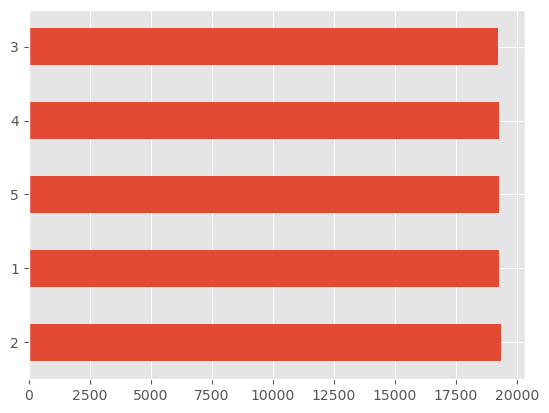

In [31]:
# Amount bins
AMOUNT = True
if AMOUNT:
      final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
      
      final['amount_cat'].value_counts().plot(kind='barh')
      plt.show()
      
      qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
      
      qcut_series.value_counts()


In [32]:
len(final.columns)

1540

In [33]:
# acceleration
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)

Cardnum
Merchnum
Merch description
Merch state
Merch zip
card_merch
card_zip
card_state
merch_zip
merch_state


C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3188752963.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3188752963.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\micha\AppData\Local\Temp\ipykernel_9648\3188752963.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [34]:
len(final.columns)

1620

In [35]:
final.to_csv('make_variables.csv',index=False)